In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import h5py
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils


In [2]:
torch.cuda.is_available()

True

In [4]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_stchresp_nasp5_qp5_N1000_trim.h5'

Ngw = gwutils.get_gwh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

cut_fraction = [0.7,0.05]
gw_dataset = gwutils.GWDatasetCutStRe(h5filename, cut_fraction, root_dir, train_index)
gw_test_dataset = gwutils.GWDatasetCutStRe(h5filename, cut_fraction, root_dir, test_index)
gw_valid_dataset = gwutils.GWDatasetCutStRe(h5filename, cut_fraction, root_dir, valid_index)


In [5]:
train_label = 'IMRPv2_q5_nas5_N1000_bicut70to95_StRe'

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [6]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=get_all_indcs, targets_getter=get_all_indcs, #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [7]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [8]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=16,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=50,
    **KWARGS
)




--- Loading IMRPv2_q5_nas5_N1000_bicut70to95_StRe/ConvCNP/run_0 ---

IMRPv2_q5_nas5_N1000_bicut70to95_StRe/ConvCNP/run_0 | best epoch: 99 | train loss: -7601.7795 | valid loss: -7734.9613 | test log likelihood: 7606.8941


In [9]:
model_imrpv2_7d = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

In [10]:
testindex = 2
x_test, y_test = gw_test_datasets[f'{train_label}'][testindex]

len_data = len(x_test)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context = x_test[context_index]
y_test_context = y_test[context_index]

x_test_target = x_test[target_index]
x_yest_target = y_test[target_index]

In [11]:
nsample = 1
mean, std = gwutils.get_predictions(model_imrpv2_7d, x_test_context.unsqueeze(0), y_test_context.unsqueeze(0),
                                    x_test_target.unsqueeze(0), nsample)

#mean=mean[0,:,0]
#std=std[0,:,0]


In [12]:
std.shape

(3920,)

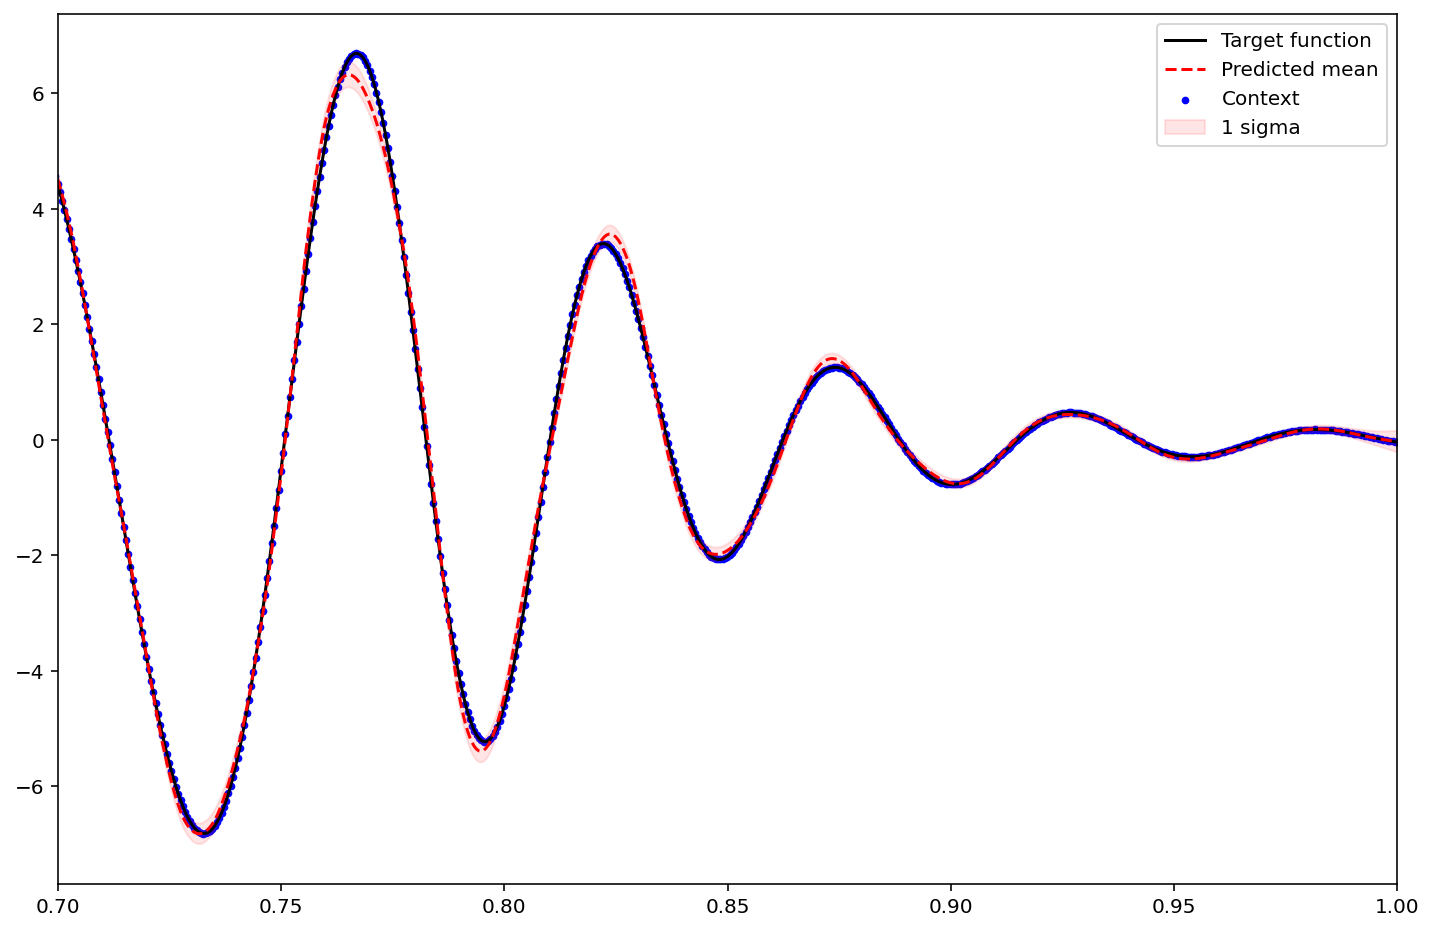

In [13]:
plt.figure(figsize=(12,8))

plt.plot(x_test, y_test, label='Target function', color='k')
plt.scatter(x_test_context, y_test_context, label='Context', color='b',s=8)
plt.plot(x_test_target, mean, label='Predicted mean', color='r',linestyle='--')
plt.fill_between(x=x_test_target.squeeze(), y1=mean-std, y2=mean+std, label='1 sigma', alpha=0.1, color='r')

plt.legend()
plt.xlim(0.7,1)
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

In [16]:
def test_plots(dataset, model, testnum=10, subplotshape=(5,2), figsize=(20,20) ):
    plt.figure(figsize=figsize)
    for testindex in range(testnum):
        x_test, y_test = dataset[testindex]

        len_data = len(x_test)
        len_context = int(len_data*1)
        context_index = np.sort( np.random.permutation(len_data)[:len_context] )
        target_index = np.arange(len_data)

        x_test_context = x_test[context_index]
        y_test_context = y_test[context_index]

        x_test_target = x_test[target_index]
        x_yest_target = y_test[target_index]

        nsample = 1
        mean, std = gwutils.get_predictions(model, x_test_context.unsqueeze(0), y_test_context.unsqueeze(0),
                                    x_test_target.unsqueeze(0), nsample)

        plt.subplot(subplotshape[0],subplotshape[1], testindex+1)
        plt.plot(x_test, y_test, label='Target function', color='k')
        plt.scatter(x_test_context, y_test_context, label='Context', color='b',s=8)
        plt.plot(x_test_target, mean, label='Predicted mean', color='r',linestyle='--')
        plt.fill_between(x=x_test_target.squeeze(), y1=mean-std, y2=mean+std, label='1 sigma', alpha=0.1, color='r')
        plt.text(x=-0.5,y=-6, s=f"test id: {testindex}")
        if testindex in [0,1]:
            plt.legend()
    
    plt.show()

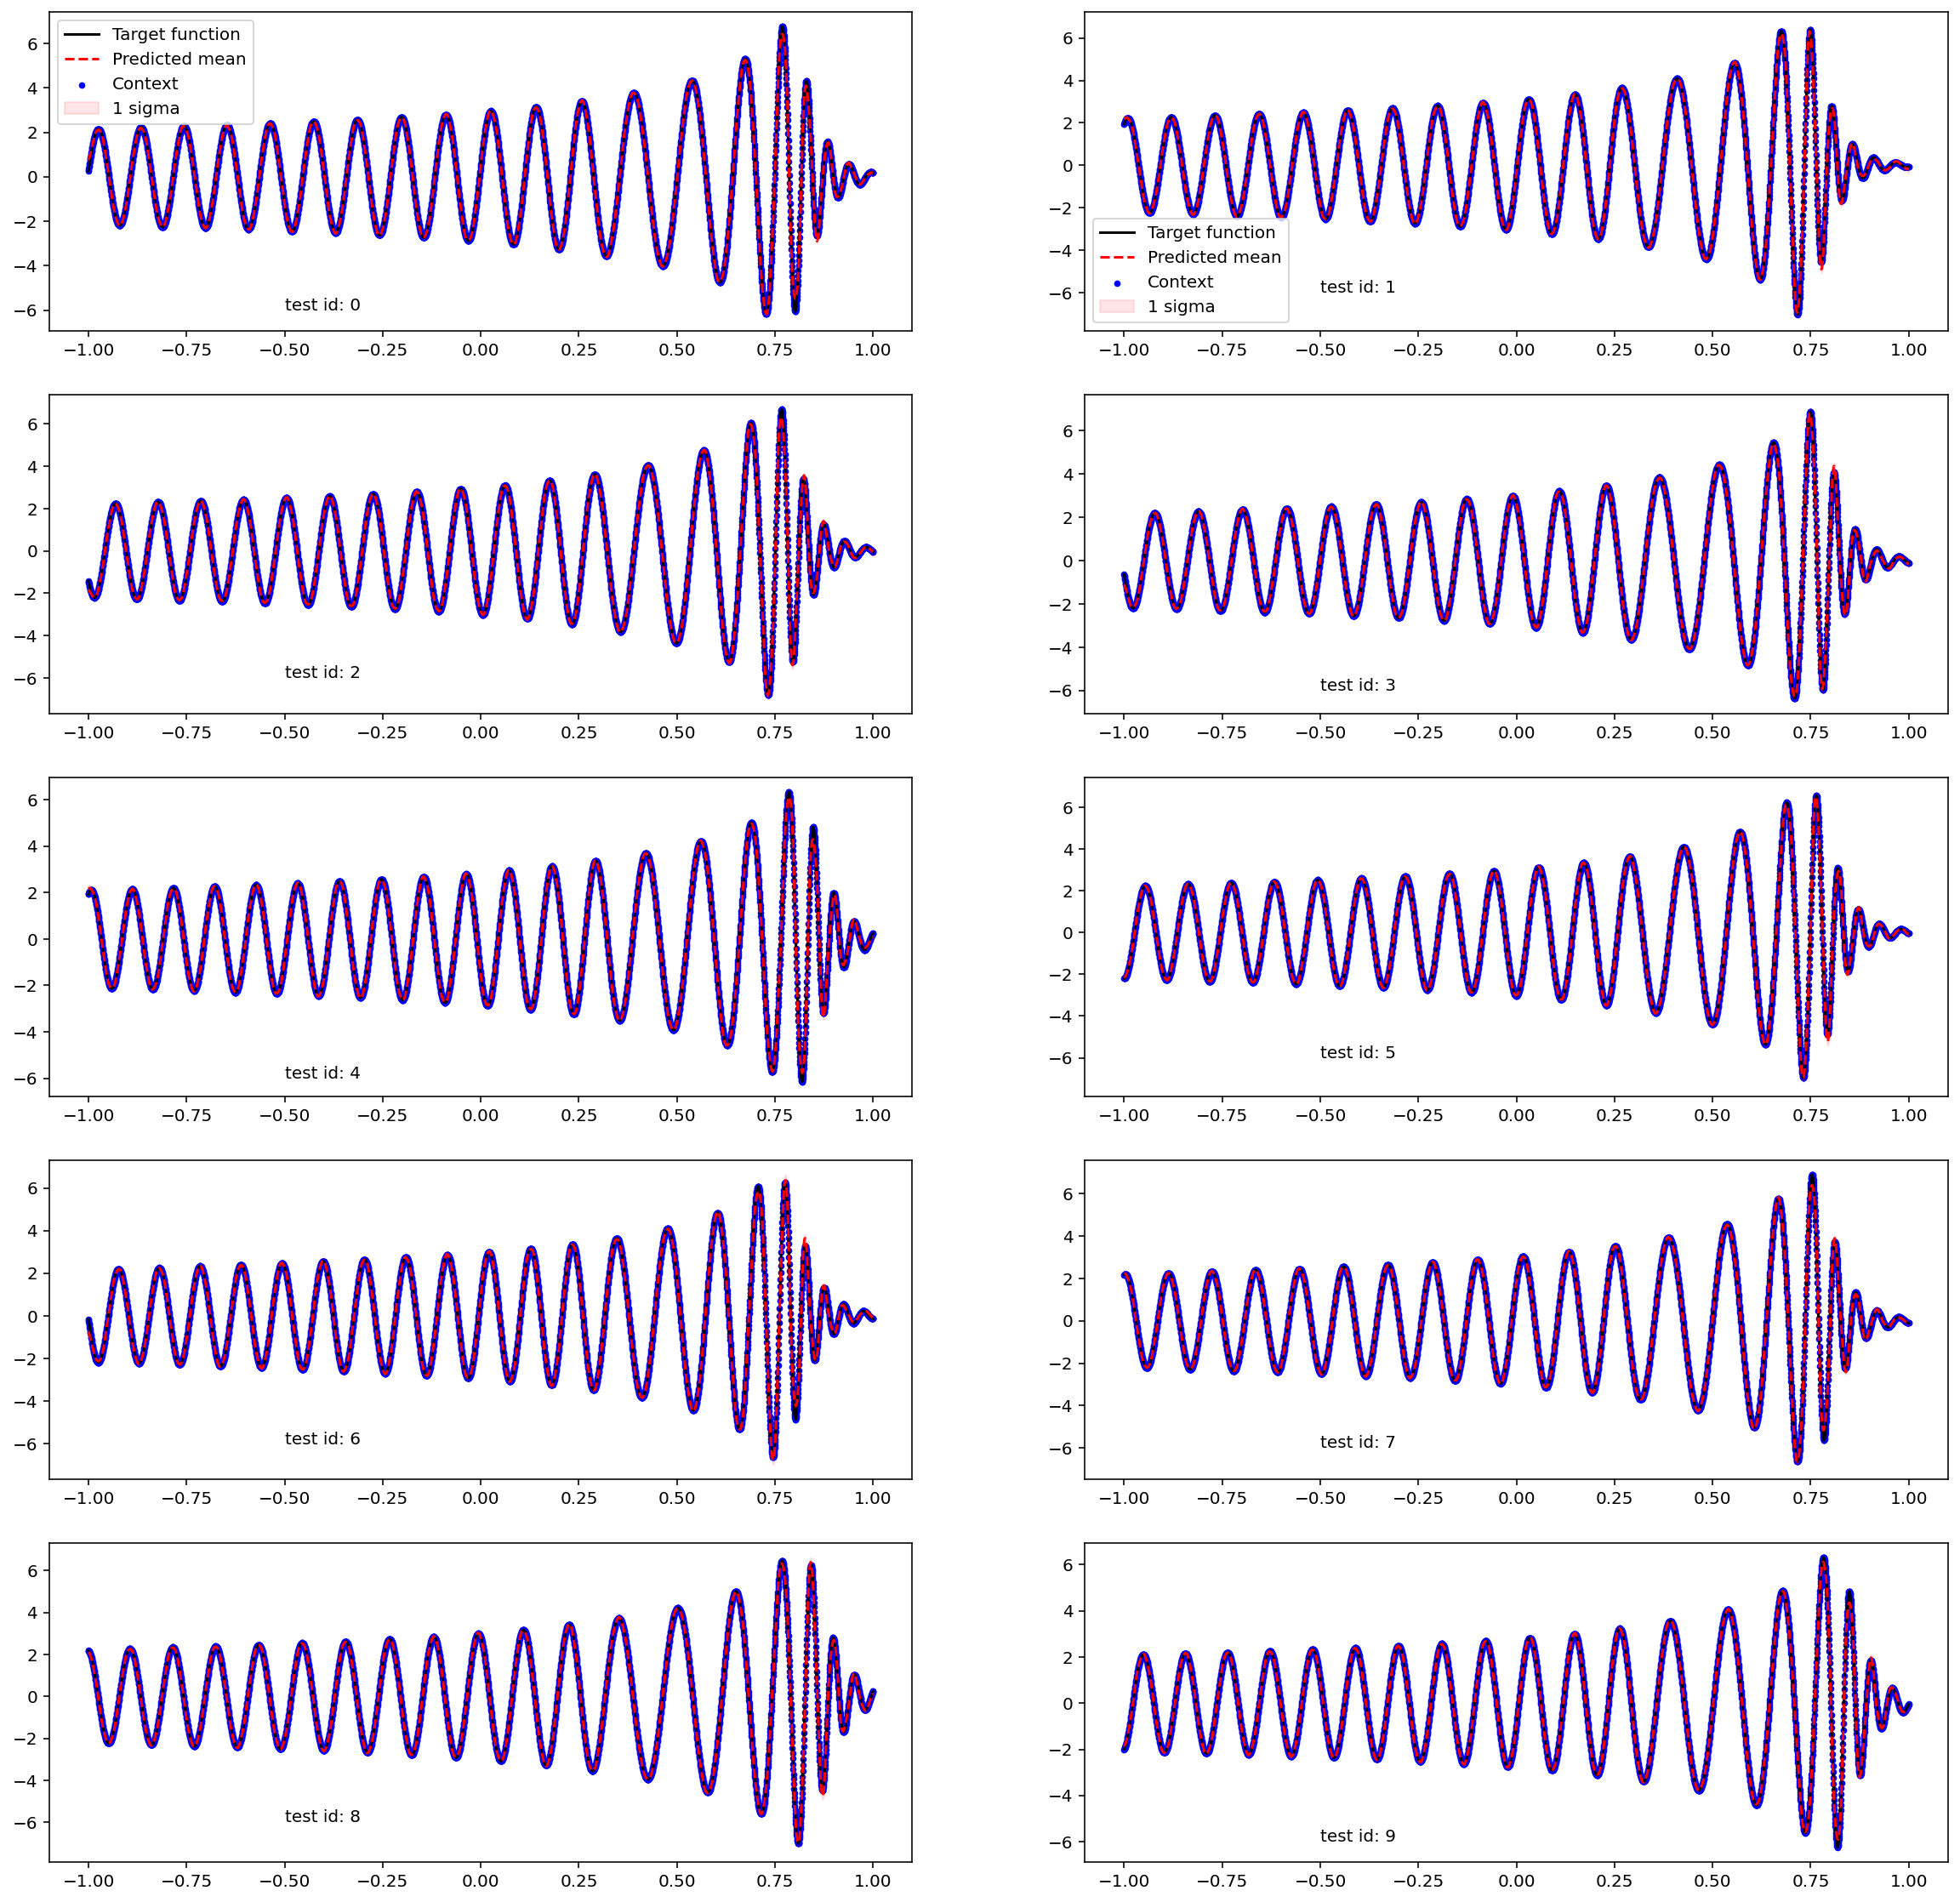

In [17]:
test_plots(dataset=gw_test_datasets[f'{train_label}'], model=model_imrpv2_7d)